In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import folium
from folium.plugins import MarkerCluster
from datetime import datetime
import seaborn as sns

In [98]:
nepal_df = pd.read_excel(r"E:\Atuda\67814-Data-Science-Final-Project\Data\Nepal\DATA.xlsx2018.xlsx")
senegal_df = pd.read_excel(r"E:\Atuda\67814-Data-Science-Final-Project\Data\Senegal\data.xlsx")

In [99]:
# 18.4 removed unncessary nepal columns
nepal_df = nepal_df.drop(['Result_Id', 'Device_Name', 'Incomplete', 'LocationStatus', 'ExtraInformation', 'Q3._Name_of_farmer',
                          'Q12._Who_makes_farming_decisions_in_this_holding_Me1', 'Q14._Did_you_participate_in_a_learning_program_abroad_for_exampl',
                          'type_of_crop_vegetables', 'Q59._A._for_surveyor_do_not_ask_farmerLook_in_the_field_does_the',
                          'Q61._A._for_surveyor_do_not_ask_farmerLook_in_the_field_does_the',
                          'Q66._A.For_surveyor_do_not_ask_farmerLook_in_the_field_does_the',
                          'Q77._for_surveyor_do_not_ask_farmerLook_in_the_field_Does_the_an',
                          'Q104._Why_do_you_want_to_have_this_number_of_childrendont_read_t', 'Q115._G.4._Please_take_a_picture_of_the_field_try_to_include_irr',
                          'hope_P', 'hope_A'], axis=1)
                            

In [100]:
BIG_TO_SQM = 6772.63
HEC_TO_SQM = 10_000
XOF_TO_USD = 575.04
NP_TO_USD = 135.1

nepal_df['target1-yearly_income_from_agr_per_land_SQM'] = nepal_df['Q108._What_is_your_households_yearly_income_from_agriculture__NP'] / (BIG_TO_SQM * (nepal_df['Q50._A._How_much_land_that_is_yours_do_you_cultivate_biggaif_the'] + nepal_df['Q51._A._How_much_land_that_is_rentedleased_do_you_cultivate_bigg']))
senegal_df['target1-yearly_income_from_agr_per_land_SQM'] = senegal_df['Q90._P.10.yearly_income_from_agriculture__XOF_x000D'] / (HEC_TO_SQM * (senegal_df['Q60._A.1._How_much_land_that_is_your_own_do_you_cultivate_hectar'] + senegal_df['Q61._A.2._How_much_land_that_is_rentedleased_do_you_cultivate_he']))

nepal_df['target2-yearly_income_from_agr_USD'] = NP_TO_USD * nepal_df['Q108._What_is_your_households_yearly_income_from_agriculture__NP']
senegal_df['target2-yearly_income_from_agr_USD'] = XOF_TO_USD * senegal_df['Q90._P.10.yearly_income_from_agriculture__XOF_x000D']

nepal_df['target3-veg_per_area'] = nepal_df['Q62._A._How_much_VEGETABLES_do_you_harvest_per_year_from_this_pl'] / (BIG_TO_SQM * (nepal_df['Q50._A._How_much_land_that_is_yours_do_you_cultivate_biggaif_the'] + nepal_df['Q51._A._How_much_land_that_is_rentedleased_do_you_cultivate_bigg']))
senegal_df['target3-veg_per_area'] = senegal_df['Q71._A.10._How_much_VEGETABLES_do_you_harvest_per_year_from_this'] / (HEC_TO_SQM * (senegal_df['Q60._A.1._How_much_land_that_is_your_own_do_you_cultivate_hectar'] + senegal_df['Q61._A.2._How_much_land_that_is_rentedleased_do_you_cultivate_he']))

nepal_df.rename(columns={'Q112._G.2._Generally_speaking_how_would_you_define_your_farming': 'target4-self-farming-perception'}, inplace=True)
nepal_df.rename(columns={'Q94._S.2._Generally_speaking_how_would_you_define_your_farming_i': 'target4-self-farming-perception'}, inplace=True)

In [101]:
# 18.4 created datetime column

nepal_df['Surveyed_Date'] = pd.to_datetime(nepal_df['Surveyed_Date'], errors='coerce')

def create_datetime_col(df):
    # Convert both columns to strings and parse
    dt = pd.to_datetime(
        df['Surveyed_Date'].dt.strftime('%Y-%m-%d') + ' ' +
        df['Surveyed_Time'].astype(str)
    )
    df['Surveyed_DateTime'] = dt.dt.tz_localize(None)
    
    # Check
    print(df['Surveyed_DateTime'].dtype)
    # → datetime64[ns]
    
create_datetime_col(nepal_df)
create_datetime_col(senegal_df)

datetime64[ns]
datetime64[ns]


In [102]:
# 23.4 removed since already have DateTime column
nepal_df = nepal_df.drop(['Surveyed_Date', 'Surveyed_Time', 'Surveyed'], axis=1)
senegal_df = senegal_df.drop(['Surveyed_Date', 'Surveyed_Time'], axis=1)

In [103]:
# 18.4 define function to analyze new datetime columns

def analyze_datetime(df, col):
    """
    Perform univariate analysis on a datetime64 column:
      - prints basic stats (min, max, missing)
      - plots counts per day, month, weekday, and hour-of-day
    """
    # Basic info
    series = df[col]
    if not series.dtype.name.startswith('datetime'):
        raise ValueError(f"Column {col!r} is not datetime dtype.")
    
    print(f"\n--- ANALYSIS OF {col.upper()} ---")
    print(f"Type: {series.dtype}")
    print(f"Missing: {series.isna().sum()} / {len(series)}")
    print(f"Range: {series.min()} → {series.max()}")
    
    # Extract time features
    df_temp = df.dropna(subset=[col]).copy()
    df_temp['date']    = df_temp[col].dt.date
    df_temp['month']   = df_temp[col].dt.to_period('M').astype(str)
    df_temp['weekday'] = df_temp[col].dt.day_name()
    df_temp['hour']    = df_temp[col].dt.hour
    
    # 1. Counts per day
    daily = df_temp.groupby('date').size()
    plt.figure()
    daily.plot(kind='bar')
    plt.title(f"Number of Records per Day ({col})")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Counts by month
    monthly = df_temp.groupby('month').size().sort_index()
    plt.figure()
    monthly.plot(kind='bar')
    plt.title(f"Counts by Month ({col})")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Counts by weekday
    # ensure Mon–Sun order
    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    wd = df_temp['weekday'].value_counts().reindex(weekdays)
    plt.figure()
    wd.plot(kind='bar')
    plt.title(f"Counts by Weekday ({col})")
    plt.xlabel("Weekday")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # 4. Distribution of hour of day
    plt.figure()
    sns.histplot(df_temp['hour'], bins=24, discrete=True, kde=False)
    plt.title(f"Survey Time of Day Distribution ({col})")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count")
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()

    

NEPAL DATA

--- ANALYSIS OF SURVEYED_DATETIME ---
Type: datetime64[ns]
Missing: 0 / 268
Range: 2018-11-06 08:36:08 → 2019-01-11 07:41:10


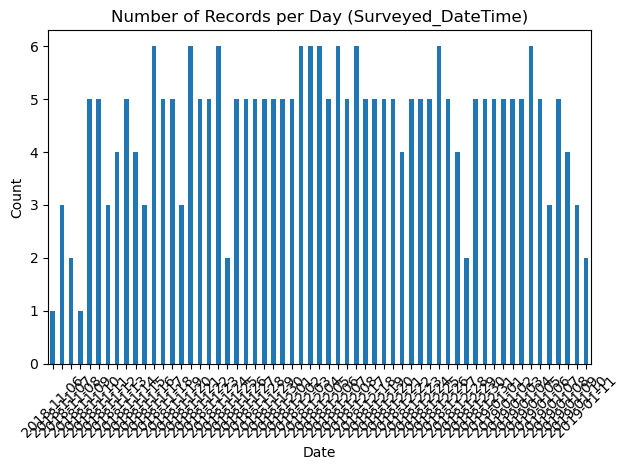

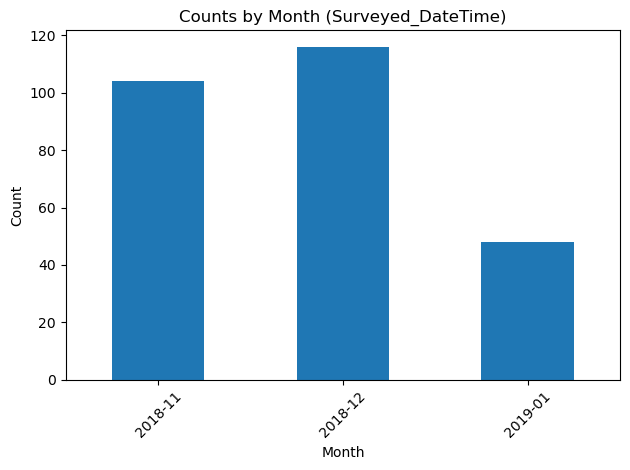

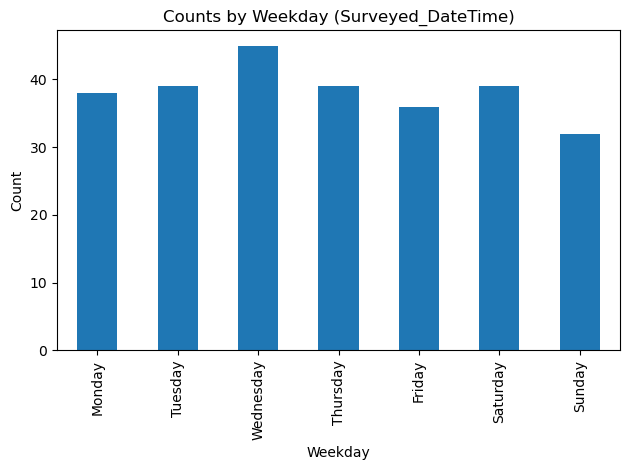

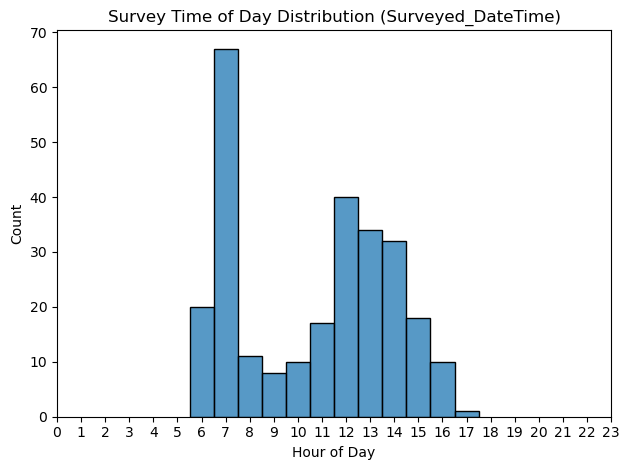

SENEGAL DATA

--- ANALYSIS OF SURVEYED_DATETIME ---
Type: datetime64[ns]
Missing: 0 / 335
Range: 2018-03-27 09:28:42 → 2018-05-02 13:15:37


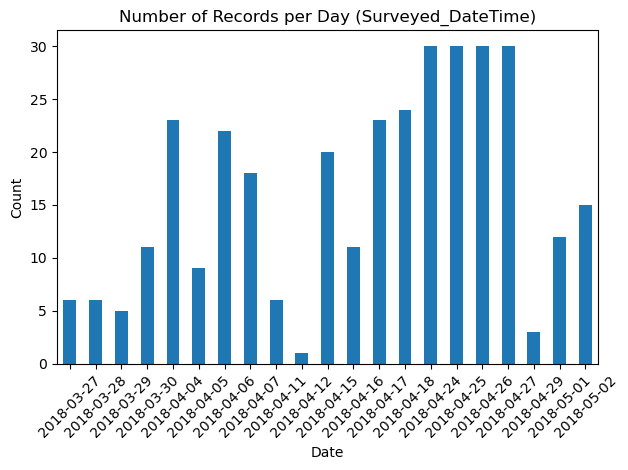

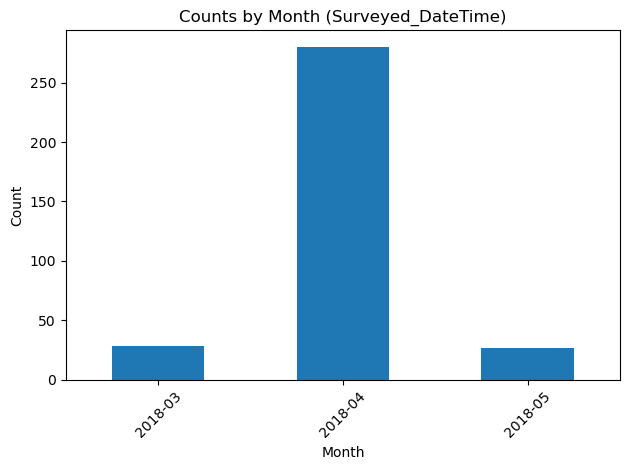

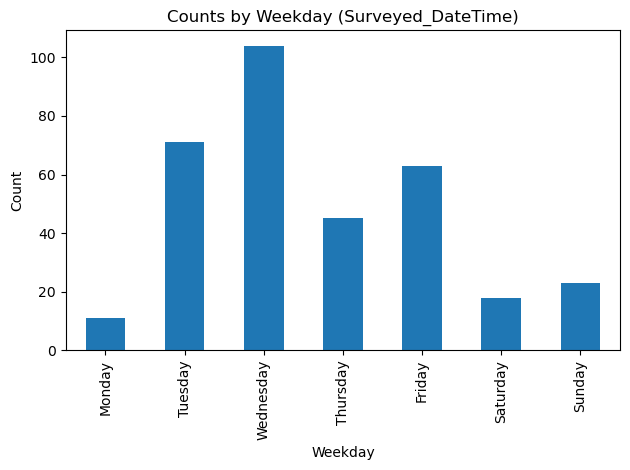

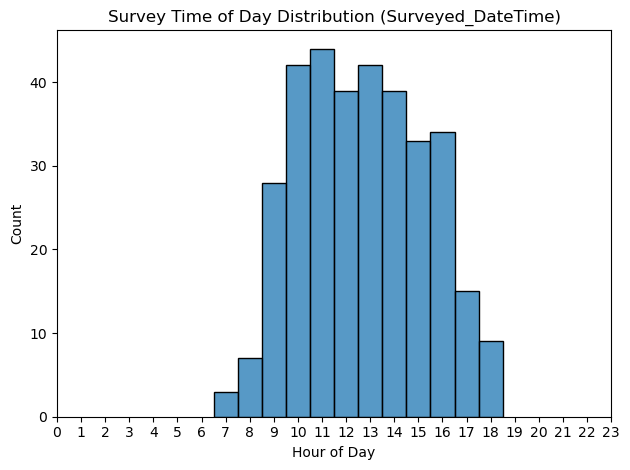

In [104]:
# 18.4 analyze new datetime columns
print("NEPAL DATA")
analyze_datetime(nepal_df, 'Surveyed_DateTime')
print("SENEGAL DATA")
analyze_datetime(senegal_df, 'Surveyed_DateTime')

In [105]:
# 23.4 add Survey_Length column
nepal_df.rename(columns={'how_long_was_the_survey': 'Survey_Length'}, inplace=True)
# turn time → "HH:MM:SS" strings → Timedelta
nepal_df['Survey_Length'] = (
    nepal_df['Survey_Length']
      .astype(str)                # datetime.time → "HH:MM:SS"
      .pipe(pd.to_timedelta)      # parse into timedelta64[ns]
)

senegal_df['Surveyed_DateTime'] = pd.to_datetime(senegal_df['Surveyed_DateTime'])
senegal_df['Surveyed_End_Date'] = pd.to_datetime(senegal_df['Surveyed_End_Date'])
senegal_df['Survey_Length'] = (
    senegal_df['Surveyed_End_Date']
  - senegal_df['Surveyed_DateTime']
)

In [106]:
# 23.4 functuion to analyze Survey_Length column
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Survey_Length', bins=30):
    """
    Analyze the distribution of survey lengths in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # Ensure the column is timedelta64[ns]
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # Compute statistics
    mean_td = df[column].mean()
    std_td = df[column].std()

    # Convert to total seconds for plotting
    secs = df[column].dt.total_seconds()

    # Plot histogram
    fig, ax = plt.subplots()
    ax.hist(secs, bins=bins)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter to convert seconds back to HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print mean and std in HH:MM:SS
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

NEPAL DATA


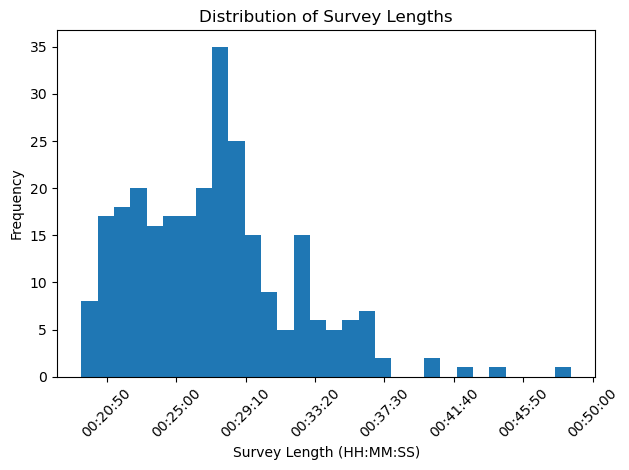

Mean survey length: 00:27:15.940298507
Std dev survey length: 00:04:48.473153806
SENEGAL DATA


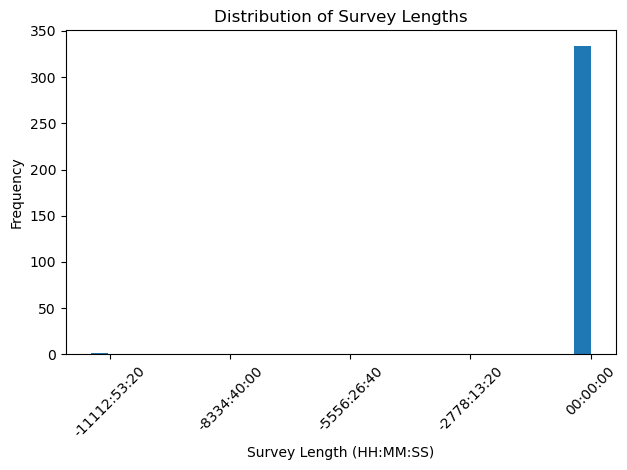

Mean survey length: +14:03:00.797014926
Std dev survey length: 07:31:02.226712886


(Timedelta('-2 days +14:03:00.797014926'),
 Timedelta('26 days 07:31:02.226712886'))

In [107]:
print("NEPAL DATA")
analyze_survey_length(nepal_df)
print("SENEGAL DATA")
analyze_survey_length(senegal_df)

In [108]:
# 23.4 discovered data-entry glitch extreme value at one senegalese survey

bad = senegal_df[ senegal_df['Survey_Length'] < pd.Timedelta(0) ]
print(bad[['Surveyed_DateTime','Surveyed_End_Date','Survey_Length']])

      Surveyed_DateTime   Surveyed_End_Date       Survey_Length
328 2018-04-27 14:18:09 2017-01-01 00:11:33 -482 days +09:53:24


In [109]:
# 23.4 filling in this survey with median survey length
median_td = senegal_df.loc[ senegal_df['Survey_Length'] >= pd.Timedelta(0), 'Survey_Length' ].median()
mask = senegal_df['Survey_Length'] < pd.Timedelta(0)
print(f"Found {mask.sum()} negative Survey_Length(s), filling with median = {median_td}")
senegal_df.loc[mask, 'Survey_Length'] = median_td

Found 1 negative Survey_Length(s), filling with median = 0 days 00:31:58


In [110]:
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Survey_Length', bins=30, max_std=3):
    """
    Analyze the distribution of survey lengths in a DataFrame,
    and overlay vertical lines at mean ± n * std for n = 1..max_std.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.
    max_std : int, default 3
        How many standard-deviation multiples to draw lines for.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution with σ-lines.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # 1) Type check
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # 2) Compute statistics
    mean_td = df[column].mean()
    std_td  = df[column].std()

    mean_sec = mean_td.total_seconds()
    std_sec  = std_td.total_seconds()

    # 3) Build histogram
    secs = df[column].dt.total_seconds()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(secs, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter: seconds → HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)

    # 4) Overlay mean and std-bands
    #    use different linestyles/colors for clarity
    for n in range(0, max_std+1):
        # skip n=0 since that’s the mean line (draw it separately for legend clarity)
        if n == 0:
            ax.axvline(mean_sec, color='black', linestyle='-', linewidth=2,
                       label='Mean')
        else:
            for sign, label in [(+1, f'+{n}σ'), (-1, f'-{n}σ')]:
                x = mean_sec + sign * n * std_sec
                ax.axvline(x, linestyle='--' if n==1 else ':',
                           linewidth=1.5 if n==1 else 1,
                           label=label if sign>0 else None)
    # Only one -σ label needed, so we skip labeling the negative side

    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 5) Print out
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

SENEGAL DATA


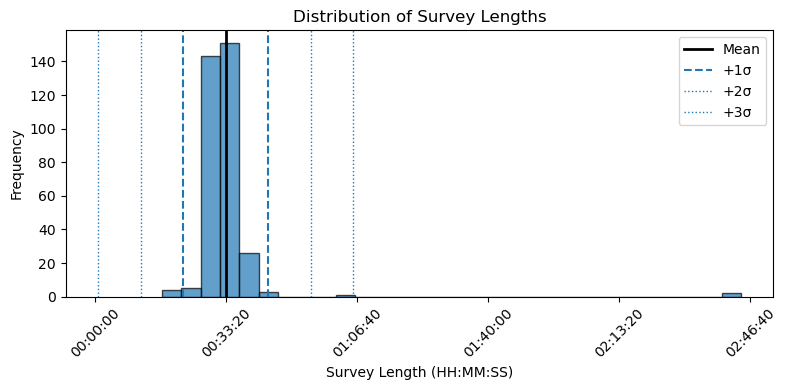

Mean survey length: 00:33:13.077611940
Std dev survey length: 00:10:49.001886783


(Timedelta('0 days 00:33:13.077611940'),
 Timedelta('0 days 00:10:49.001886783'))

In [111]:
print("SENEGAL DATA")
analyze_survey_length(senegal_df)

In [112]:
threshold = senegal_df['Survey_Length'].mean() + 2*senegal_df['Survey_Length'].std()
mask = senegal_df['Survey_Length'] > threshold
print(f"Changed {mask.sum()} outlier survey lengths to median")
senegal_df.loc[mask, 'Survey_Length'] = median_td

Changed 3 outlier survey lengths to median


SENEGAL DATA


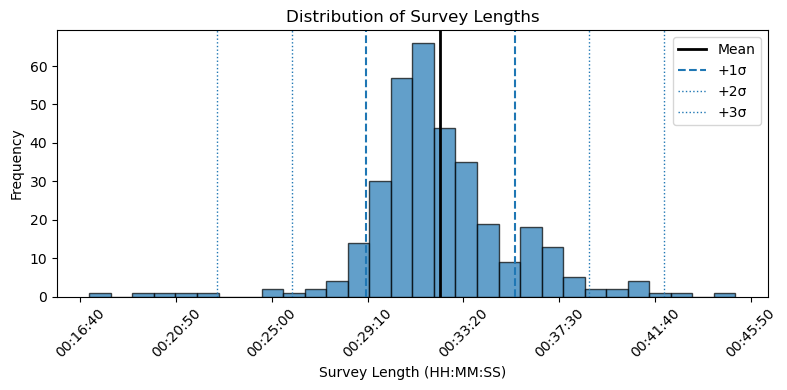

Mean survey length: 00:32:20.020895522
Std dev survey length: 00:03:14.135769931


(Timedelta('0 days 00:32:20.020895522'),
 Timedelta('0 days 00:03:14.135769931'))

In [113]:
print("SENEGAL DATA")
analyze_survey_length(senegal_df)

In [114]:
# 23.4 since added Survey_Length column, took out others
nepal_df = nepal_df.drop(['End'], axis=1)
senegal_df = senegal_df.drop(['Surveyed_End_Date'], axis=1)

In [115]:
# 23.4 missing columns in senegal Location_ columns
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Location_{column}: {senegal_df[f'Location_{column}'].isna().sum()}")
    print(f"missing values in {column}: {senegal_df[column].isna().sum()}")


missing values in Location_Latitude: 335
missing values in Latitude: 0
missing values in Location_Longitude: 335
missing values in Longitude: 0
missing values in Location_Altitude: 335
missing values in Altitude: 0
missing values in Location_Accuracy: 335
missing values in Accuracy: 0


In [116]:
# 23.4 removing Location_ columns from senegal data
senegal_df = senegal_df.drop(['Location_Latitude', 'Location_Longitude', 'Location_Altitude', 'Location_Accuracy'], axis=1)

In [117]:
# 23.4 both ok for nepal
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Location_{column}: {nepal_df[f'Location_{column}'].isna().sum()}")
    print(f"missing values in {column}: {nepal_df[column].isna().sum()}")

missing values in Location_Latitude: 0
missing values in Latitude: 0
missing values in Location_Longitude: 0
missing values in Longitude: 0
missing values in Location_Altitude: 0
missing values in Altitude: 0
missing values in Location_Accuracy: 0
missing values in Accuracy: 0


In [118]:
# 23.4 still removing from nepal Location_ columns for consistency between both datasets
nepal_df = nepal_df.drop(['Location_Latitude', 'Location_Longitude', 'Location_Altitude', 'Location_Accuracy'], axis=1)

In [119]:

from folium.plugins import MarkerCluster

def lat_lon_hillshade_map(df, zoom_start=11):
    """
    Folium map with:
      • Default OpenStreetMap layer
      • ESRI World Hillshade (true terrain) layer
      • MarkerCluster of your points with Altitude pop-ups
      • LayerControl for toggling back and forth
    """
    # 1) Prepare & center
    df_map = df.dropna(subset=['Latitude','Longitude']).copy()
    center = [df_map['Latitude'].mean(), df_map['Longitude'].mean()]

    # 2) Build base map (OSM by default)
    m = folium.Map(location=center, zoom_start=zoom_start)

    # 3) Add ESRI World Hillshade as a second base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/'
              'Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles © Esri — Source: USGS',
        name='Hillshade (ESRI)'
    ).add_to(m)

    # 4) Your markers (clustered)
    mc = MarkerCluster(name='Points').add_to(m)
    for idx, row in df_map.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=(
                f"<b>Index:</b> {idx}<br>"
                f"<b>Altitude:</b> {row.get('Altitude','N/A')} m"
            )
        ).add_to(mc)

    # 5) Toggle control
    folium.LayerControl(collapsed=False).add_to(m)

    return m


In [120]:
# analyze lat long data for nepal
nepal_map = lat_lon_hillshade_map(nepal_df)
nepal_map   # in Jupyter this will render with two base‐layers to switch between


In [121]:
# analyze lat long data for senegal
print("SENEGAL DATA")
senegal_map = lat_lon_hillshade_map(senegal_df)
senegal_map


SENEGAL DATA


In [122]:
import requests

def plot_altitude_error(df, lat_col='Latitude', lon_col='Longitude', alt_col='Altitude', accuracy_col='Accuracy', api_url='https://api.open-elevation.com/api/v1/lookup', batch_size=100, bins=30):
    '''
    Fetches true elevations and plots a combined view showing:
      - Histogram of altitude errors (recorded - true).
      - Median reported accuracy for each error bin overlaid as a line.

    Parameters:
    df (pd.DataFrame): DataFrame with latitude, longitude, recorded altitude, and accuracy columns.
    lat_col (str): Name of the latitude column.
    lon_col (str): Name of the longitude column.
    alt_col (str): Name of the recorded altitude column.
    accuracy_col (str): Name of the accuracy column.
    api_url (str): Elevation API endpoint.
    batch_size (int): Number of locations per API request.
    bins (int): Number of bins for error histogram and averaging.

    Returns:
    None. Displays a joint plot of error distribution and median accuracy per error bin.
    '''
    # Work on a copy
    df = df.copy()
    true_alts = []

    # Batch request loop to fetch true elevations
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        locations = '|'.join(f"{lat},{lon}" for lat, lon in zip(batch[lat_col], batch[lon_col]))
        resp = requests.get(api_url, params={'locations': locations})
        resp.raise_for_status()
        results = resp.json().get('results', [])
        if len(results) != len(batch):
            raise ValueError(f"Expected {len(batch)} results, got {len(results)}")
        true_alts.extend(r['elevation'] for r in results)

    # Compute errors and extract accuracy
    recorded = df[alt_col].values
    errors = recorded - np.array(true_alts)
    accuracies = df[accuracy_col].values

    # Prepare bins and compute median accuracy per bin
    bin_edges = np.linspace(errors.min(), errors.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    digitized = np.digitize(errors, bin_edges) - 1
    median_acc = [np.median(accuracies[digitized == i]) if np.any(digitized == i) else np.nan for i in range(bins)]

    # Create combined plot
    fig, ax1 = plt.subplots()

    # Histogram of errors
    ax1.hist(errors, bins=bin_edges, alpha=0.6)
    ax1.set_xlabel('Altitude Error (m)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(0, color='k', linestyle='--')

    # Overlay median accuracy line on a twin y-axis
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, median_acc, marker='o', linestyle='-')
    ax2.set_ylabel('Median Reported Accuracy')

    plt.title('Altitude Error Distribution with Median Accuracy per Error Bin')
    plt.show()

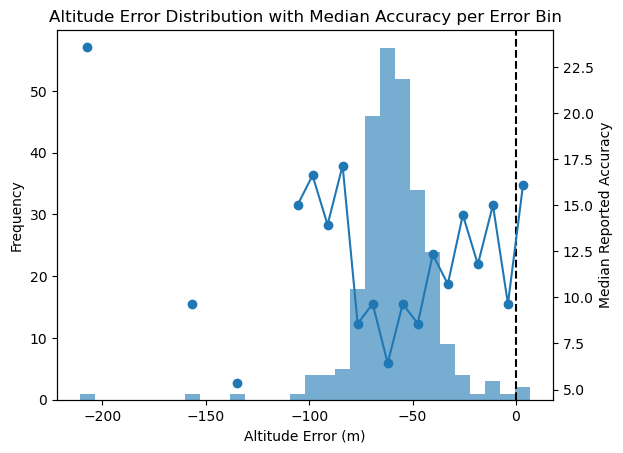

In [123]:
plot_altitude_error(nepal_df)

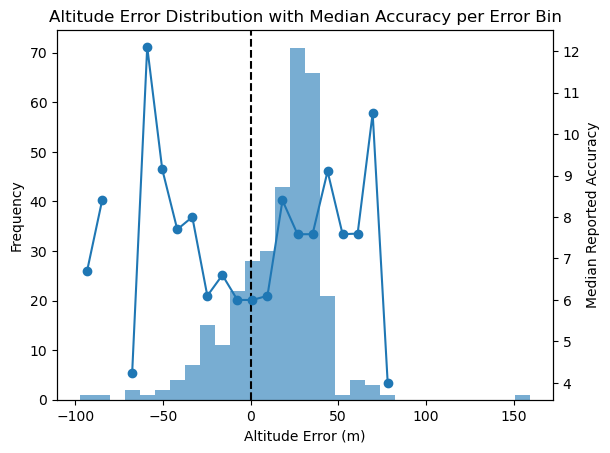

In [52]:
plot_altitude_error(senegal_df)

In [125]:
nepal_df = nepal_df.drop(['Altitude'], axis=1)
senegal_df = senegal_df.drop(['Altitude'], axis=1)

In [23]:
nepal_df.describe()

,V1,Surveyed,Location_Latitude,Location_Longitude,Location_Altitude,Location_Accuracy,Latitude,Longitude,Altitude,Accuracy,...,ZQ101._how_many_people_live_in_this_household,ZDistance,ZCaste_bhramin,ZCaste_janjati,ZCaste_adhibasi,ZCaste_chettri,ZCaste_sanyasi,ZCaste_Dalit,ZCaste_Madhesi,ZCaste_Other
count,268.000000,268,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,...,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02
mean,1.469776,2018-12-09 12:05:22.388059648,26.538175,88.054369,57.817164,11.368000,26.538111,88.054320,59.694030,10.780000,...,9.942296e-16,-1.033999e-15,-1.060512e-16,-9.279476e-17,-2.651279e-16,3.976918e-16,-1.193075e-16,7.953837e-17,-9.279476e-17,-9.942296e-18
min,1.200000,2018-11-06 00:00:00,26.438749,87.910339,-23.000000,3.216000,26.439294,87.910490,-118.000000,3.216000,...,-1.755735e+00,-8.496306e-01,-7.038121e-01,-4.363462e-01,-3.804694e-01,-4.363462e-01,-2.064990e-01,-1.750840e-01,-2.757182e-01,-1.965072e-01
25%,1.500000,2018-11-23 00:00:00,26.490667,88.064756,26.000000,6.432000,26.490409,88.064283,24.750000,6.432000,...,-1.031832e+00,-7.272489e-01,-7.038121e-01,-4.363462e-01,-3.804694e-01,-4.363462e-01,-2.064990e-01,-1.750840e-01,-2.757182e-01,-1.965072e-01
50%,1.500000,2018-12-06 00:00:00,26.540713,88.070583,34.000000,9.112000,26.540803,88.070687,38.000000,9.648001,...,-3.079289e-01,-2.163462e-01,-7.038121e-01,-4.363462e-01,-3.804694e-01,-4.363462e-01,-2.064990e-01,-1.750840e-01,-2.757182e-01,-1.965072e-01
75%,1.500000,2018-12-27 00:00:00,26.549377,88.075214,43.000000,15.008000,26.548702,88.075093,51.000000,13.936001,...,4.159741e-01,3.330641e-01,1.415532e+00,-4.363462e-01,-3.804694e-01,-4.363462e-01,-2.064990e-01,-1.750840e-01,-2.757182e-01,-1.965072e-01
max,1.500000,2019-01-11 00:00:00,26.884735,88.134979,1672.000000,40.736000,26.892103,88.133588,1636.000000,36.448002,...,6.931101e+00,5.252512e+00,1.415532e+00,2.283207e+00,2.618525e+00,2.283207e+00,4.824568e+00,5.690231e+00,3.613359e+00,5.069885e+00
std,0.072028,NaN,0.061078,0.047611,181.747016,6.884521,0.061371,0.047539,179.997866,6.141781,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [68]:
def analyze_numerical(df, col):
    print(f"\n--- {col.upper()} ---")
    print(df[col].describe())
    print("Missing values:", df[col].isnull().sum())

    # Histogram
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

    # Boxplot
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()